In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

2022-05-01 18:52:06.418722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 18:52:06.418755: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train = pd.read_pickle('preprocessed_data/train.pkl')
val = pd.read_pickle('preprocessed_data/val.pkl')
test = pd.read_pickle('preprocessed_data/test.pkl')

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train.label)

train['label'] = le.transform(train['label'])
val['label'] = le.transform(val['label'])
test['label'] = le.transform(test['label'])
df_train = train
df_val = val
df_test = test

<AxesSubplot:xlabel='label'>

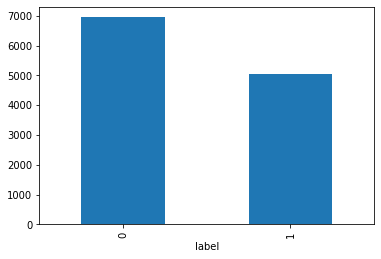

In [4]:
train.groupby(['label']).size().plot.bar()

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):

        self.labels = list(df['label'])
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['sentence']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [7]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [8]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [9]:
 def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [10]:
print(len(df_train),len(df_val), len(df_test))

11999 3001 916


In [11]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [28:58<0

Epochs: 1 | Train Loss:  0.324 | Train Accuracy:  0.607 | Val Loss:  0.304 | Val Accuracy:  0.682


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [42:02<00:00,  2.38it/s]


Epochs: 2 | Train Loss:  0.272 | Train Accuracy:  0.733 | Val Loss:  0.275 | Val Accuracy:  0.735


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [14:08<00:00,  7.08it/s]


Epochs: 3 | Train Loss:  0.230 | Train Accuracy:  0.799 | Val Loss:  0.277 | Val Accuracy:  0.737


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [29:03<00:00,  3.44it/s]


Epochs: 4 | Train Loss:  0.174 | Train Accuracy:  0.866 | Val Loss:  0.302 | Val Accuracy:  0.730


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [32:48<00:00,  3.05it/s]


Epochs: 5 | Train Loss:  0.114 | Train Accuracy:  0.930 | Val Loss:  0.346 | Val Accuracy:  0.707


In [12]:
torch.save(model.state_dict(), 'agg_teacher_model_method2.pt')

In [13]:
evaluate(model, df_test)

Test Accuracy:  0.636
